In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns

# --- Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- User-Defined Paths ---
TEST_DATA_CSV = "/content/drive/MyDrive/sign_language_dataset/small_dataset/test.csv"
TRAIN_DATA_CSV = "/content/drive/MyDrive/sign_language_dataset/small_dataset/train.csv"
VAL_DATA_CSV = "/content/drive/MyDrive/sign_language_dataset/small_dataset/val.csv"
JOINT_DIR = "/content/drive/MyDrive/sign_language_dataset/small_dataset/joint_data"


NUM_FEATURES = 237

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


In [ ]:
# !unzip -q "/content/drive/MyDrive/small_dataset.zip" -d "/content/drive/MyDrive/sign_language_dataset"

In [2]:
# --- Get Set of ALL Actual Files ---
print(f"Scanning {JOINT_DIR} for all existing files...")
actual_joint_files = set(os.listdir(JOINT_DIR))
print(f"Found {len(actual_joint_files)} actual files in {JOINT_DIR}.")


train_df = pd.read_csv(TRAIN_DATA_CSV)
val_df = pd.read_csv(VAL_DATA_CSV)
test_df = pd.read_csv(TEST_DATA_CSV)

# --- Helper Function to Clean ---
def clean_manifest(df, actual_files_set, name):
    print(f"\nCleaning {name} manifest...")
    original_size = len(df)

    # 1. Create the expected joint filename for each row
    def get_joint_filename(video_file_mp4):
        return os.path.splitext(video_file_mp4)[0] + '.csv'

    df['joint_filename'] = df['Video file'].apply(get_joint_filename)

    # 2. Create a "mask" (True/False) for rows where the file exists
    mask = df['joint_filename'].isin(actual_files_set)

    # 3. Filter the DataFrame to keep only the "True" rows
    cleaned_df = df[mask]

    # 4. Report
    cleaned_size = len(cleaned_df)
    removed_count = original_size - cleaned_size
    print(f"Removed {removed_count} rows with missing joint files.")
    print(f"Original {name} size: {original_size} | Cleaned {name} size: {cleaned_size}")

    return cleaned_df

cleaned_train_df = clean_manifest(train_df, actual_joint_files, "training")
cleaned_val_df = clean_manifest(val_df, actual_joint_files, "validation")
cleaned_test_df = clean_manifest(test_df, actual_joint_files, "test")

# --- Re-Build the Label Map ---
print("\nRe-building label map from CLEANED training data...")

# Get a sorted list of all unique glosses (words)
all_glosses = sorted(cleaned_train_df['Gloss'].unique())

# Create the map and its reverse
gloss_to_index_map = {gloss: i for i, gloss in enumerate(all_glosses)}
index_to_gloss_map = {i: gloss for i, gloss in enumerate(all_glosses)}

# This is our NEW, correct number of classes
NUM_CLASSES = len(all_glosses)

print(f"Found {NUM_CLASSES} unique classes with data. (Original was 100).")

# --- Final Validation Filter ---
# It's possible the validation set has a gloss that was completely
# removed from the training set. We must filter those out too.
original_val_size = len(cleaned_val_df)
final_val_df = cleaned_val_df[cleaned_val_df['Gloss'].isin(gloss_to_index_map.keys())]
removed_count = original_val_size - len(final_val_df)

if removed_count > 0:
    print(f"Removed {removed_count} rows from validation set (classes not in train set).")

Scanning /content/drive/MyDrive/sign_language_dataset/small_dataset/joint_data for all existing files...
Found 3488 actual files in /content/drive/MyDrive/sign_language_dataset/small_dataset/joint_data.

Cleaning training manifest...
Removed 103 rows with missing joint files.
Original training size: 1800 | Cleaned training size: 1697

Cleaning validation manifest...
Removed 19 rows with missing joint files.
Original validation size: 365 | Cleaned validation size: 346

Cleaning test manifest...
Removed 68 rows with missing joint files.
Original test size: 1286 | Cleaned test size: 1218

Re-building label map from CLEANED training data...
Found 94 unique classes with data. (Original was 100).


In [3]:
import pandas as pd
import numpy as np
import torch
import os
from torch.utils.data import Dataset

class SignLanguageDataset(Dataset):
    """
    Custom Dataset with:
    1. Truncation (max_seq_length=120)
    2. Per-FRAME Pose Normalization (Center of Mass of ALL joints)
    3. Augmentations (Jitter, Scale, Temporal Dropout)
    """
    def __init__(self, manifest_df, joint_dir, gloss_to_index_map, apply_augmentation=False):
        self.manifest = manifest_df
        self.joint_dir = joint_dir
        self.gloss_to_index_map = gloss_to_index_map
        self.apply_augmentation = apply_augmentation

        # 237 features / 3 coords = 79 joints
        self.num_joints = 79
        self.num_features = 237

        self.max_seq_length = 120

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        # 1. Get row
        row = self.manifest.iloc[idx].copy()
        video_filename_mp4 = row['Video file']
        gloss = row['Gloss']

        # 2. Construct path
        joint_filename = os.path.splitext(video_filename_mp4)[0] + '.csv'
        joint_filepath = os.path.join(self.joint_dir, joint_filename)

        # 3. Load data
        try:
            pose_data_df = pd.read_csv(joint_filepath)
            pose_sequence = pose_data_df.drop(columns=['frame']).values
            if pose_sequence.shape[0] == 0: # Handle empty files
                return torch.zeros((10, self.num_features)), torch.tensor(0)
        except Exception as e:
            print(f"Error loading {joint_filepath}: {e}")
            return torch.zeros((10, self.num_features)), torch.tensor(0)

        # 3b. Truncate Long Sequences
        if pose_sequence.shape[0] > self.max_seq_length:
            pose_sequence = pose_sequence[:self.max_seq_length]
        # -------------------------------------

        # 4. --- (THE REQUESTED LOGIC) Per-Frame Pose Normalization ---
        normalized_sequence = []

        for frame_data in pose_sequence:
            # Reshape to (79 joints, 3 coords)
            joints = frame_data.reshape(self.num_joints, 3)

            # 1. Center: Calculate Center of Mass of ALL joints for THIS frame
            center_of_mass = np.mean(joints, axis=0)
            centered_joints = joints - center_of_mass

            # 2. Scale: Calculate Max Deviation for THIS frame
            max_val = np.max(np.abs(centered_joints))

            if max_val > 0:
                scaled_joints = centered_joints / max_val
            else:
                scaled_joints = centered_joints

            # Flatten back to (237,)
            normalized_frame = scaled_joints.flatten()
            normalized_sequence.append(normalized_frame)

        # Re-stack the normalized frames
        pose_sequence = np.stack(normalized_sequence)
        # ---------------------------------------------

        # 5. Data Augmentation
        if self.apply_augmentation:

            # --- Jitter ---
            noise = np.random.normal(0, 0.005, pose_sequence.shape)
            pose_sequence = pose_sequence + noise

            # --- Scaling ---
            scale_factor = np.random.uniform(0.9, 1.1)
            pose_sequence = pose_sequence * scale_factor


        # 6. Convert to PyTorch tensors
        pose_tensor = torch.tensor(pose_sequence, dtype=torch.float32)
        label_index = self.gloss_to_index_map[gloss]
        label_tensor = torch.tensor(label_index, dtype=torch.long)

        return pose_tensor, label_tensor

In [4]:
def collate_fn(batch):
    """
    Custom collate function to handle padding for sequences of different lengths.
    """
    sequences = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    lengths = torch.tensor([len(seq) for seq in sequences], dtype=torch.long)

    # Pad sequences
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0.0)

    labels = torch.stack(labels)

    return padded_sequences, labels, lengths

In [5]:
# --- Hyperparameters ---
BATCH_SIZE = 450

# --- Create Datasets ---
# We pass the pre-cleaned DataFrames directly
train_dataset = SignLanguageDataset(
    cleaned_train_df,
    JOINT_DIR,
    gloss_to_index_map,
    apply_augmentation=True
)

val_dataset = SignLanguageDataset(
    final_val_df,
    JOINT_DIR,
    gloss_to_index_map,
    apply_augmentation=False
)

# --- Create DataLoaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print("\nDataLoaders created successfully with CLEANED data.")
print(f"Total Training samples: {len(train_dataset)}")
print(f"Total Validation samples: {len(val_dataset)}")
print(f"Number of classes to predict: {NUM_CLASSES}")


DataLoaders created successfully with CLEANED data.
Total Training samples: 1697
Total Validation samples: 346
Number of classes to predict: 94


In [6]:
class PoseLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(PoseLSTM, self).__init__()

        # Make the LSTM bidirectional
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0,
            bidirectional=True
        )

        self.fc_head = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(hidden_size * 2, output_size)
        )

    def forward(self, x):
        # x shape: (Batch_Size, Seq_Length, Input_Size)

        lstm_out, (hidden_state, cell_state) = self.lstm(x)

        # We need to combine the final hidden states from both directions
        # hidden_state shape: (Num_Layers * 2, Batch_Size, Hidden_Size)

        # Get the last layer's hidden state (forward)
        fwd_hidden = hidden_state[-2, :, :] # (Batch_Size, Hidden_Size)
        # Get the last layer's hidden state (backward)
        bwd_hidden = hidden_state[-1, :, :] # (Batch_Size, Hidden_Size)

        # Concatenate them
        combined_hidden = torch.cat((fwd_hidden, bwd_hidden), dim=1)
        # combined_hidden shape: (Batch_Size, Hidden_Size * 2)

        # Pass through our new classifier head
        output = self.fc_head(combined_hidden)

        return output

In [7]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create a matrix of [max_len, d_model] representing positional information
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        # Apply sine to even indices and cosine to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Add a batch dimension: [1, max_len, d_model]
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model]
        # Add position encoding to the input embedding
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class PoseTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=256, nhead=4, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(PoseTransformer, self).__init__()

        # 1. Embedding Layer
        # Projects your 237 features up to the Transformer's dimension (e.g., 256)
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 2. Positional Encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # 3. Transformer Encoder
        # batch_first=True matches your DataLoader output (Batch, Seq, Feature)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # 4. Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim] (e.g., 32, 120, 237)

        # 1. Embed and add position info
        x = self.embedding(x)  # -> [32, 120, 256]
        x = self.pos_encoder(x)

        # 2. Pass through Transformer
        # This allows every frame to "look at" every other frame
        x = self.transformer_encoder(x) # -> [32, 120, 256]

        # 3. Pooling
        x = x.mean(dim=1)

        # 4. Classify
        output = self.classifier(x)
        return output

In [8]:
import numpy as np
import torch

class EarlyStopping:
    """Stops training when validation loss hasn't improved for a given 'patience'."""
    def __init__(self, patience=20, verbose=True, delta=0, path='best_model.pth', trace_func=print):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model, epoch):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, epoch)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, epoch):
        '''Saves model when validation loss decreases.'''
        if epoch < 150:
          return
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [9]:
def calculate_topk_accuracy(output, target, k=5):
    """
    Computes the accuracy over the k top predictions for the specified values of k.
    """
    with torch.no_grad():
        batch_size = target.size(0)
        # Get the top k indices
        _, pred = output.topk(k, 1, True, True)
        pred = pred.t()
        # Check if the true label is in the top k predictions
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        # Sum up correct predictions
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        # Return percentage
        return correct_k.mul_(100.0 / batch_size).item()

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.tensorboard import SummaryWriter

# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # --- Check for GPU ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")


# HIDDEN_SIZE = 512
# NUM_LAYERS = 2
# LEARNING_RATE = 0.0001
# NUM_EPOCHS = 500
# GRAD_CLIP_VALUE = 1.0

# train_losses = []
# val_losses = []
# train_accs = []
# val_accs = []

# train_top5_accs = []
# val_top5_accs = []


# model = PoseLSTM(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

# scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=35)

# model_save_path = '/content/drive/MyDrive/face_global_norm_sign_language_model.pth'
# early_stopping = EarlyStopping(patience=75, verbose=True, path=model_save_path)

# # --- (Initialize TensorBoard) ---
# writer = SummaryWriter('runs/my_bidirectional_lstm_v2')

# print("Starting training with Early Stopping and LR Scheduler...")

# for epoch in range(NUM_EPOCHS):
#     model.train()
#     running_loss = 0.0
#     correct_train = 0
#     correct_train_top5 = 0
#     total_train = 0

#     for padded_sequences, labels, lengths in train_loader:
#         padded_sequences = padded_sequences.to(device)
#         labels = labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(padded_sequences)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
#         optimizer.step()

#         running_loss += loss.item() * padded_sequences.size(0)
#         _, predicted = torch.max(outputs.data, 1)
#         total_train += labels.size(0)
#         correct_train += (predicted == labels).sum().item()

#         batch_top5_acc = calculate_topk_accuracy(outputs, labels, k=5)
#         correct_train_top5 += (batch_top5_acc * labels.size(0)) / 100.0

#     epoch_loss = running_loss / len(train_loader.dataset)
#     epoch_acc = 100 * correct_train / total_train
#     epoch_top5_acc = 100 * correct_train_top5 / total_train

#     # --- Validation Loop ---
#     model.eval()
#     val_running_loss = 0.0
#     correct_val = 0
#     correct_val_top5 = 0
#     total_val = 0


#     with torch.no_grad():
#         for val_seq, val_labels, val_lengths in val_loader:
#             val_seq = val_seq.to(device)
#             val_labels = val_labels.to(device)

#             val_outputs = model(val_seq)
#             val_loss = criterion(val_outputs, val_labels)
#             val_running_loss += val_loss.item() * val_seq.size(0)

#             _, val_predicted = torch.max(val_outputs.data, 1)
#             total_val += val_labels.size(0)
#             correct_val += (val_predicted == val_labels).sum().item()

#             batch_val_top5 = calculate_topk_accuracy(val_outputs, val_labels, k=5)
#             correct_val_top5 += (batch_val_top5 * val_labels.size(0)) / 100.0

#     epoch_val_loss = val_running_loss / len(val_loader.dataset)
#     epoch_val_acc = 100 * correct_val / total_val
#     epoch_val_top5_acc = 100 * correct_val_top5 / total_val

#     print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

#     train_losses.append(epoch_loss)
#     val_losses.append(epoch_val_loss)
#     train_accs.append(epoch_acc)
#     val_accs.append(epoch_val_acc)

#     train_top5_accs.append(epoch_top5_acc)
#     val_top5_accs.append(epoch_val_top5_acc)


#     # 1. Give the scheduler the validation loss
#     scheduler.step(epoch_val_loss)

#     # 2. Give Early Stopping the validation loss and model
#     early_stopping(epoch_val_loss, model, epoch)

#     if early_stopping.early_stop:
#         print("Early stopping")
#         break

#     # --- Log to TensorBoard ---
#     writer.add_scalar('Loss/train', epoch_loss, epoch)
#     writer.add_scalar('Loss/val', epoch_val_loss, epoch)
#     writer.add_scalar('Accuracy/train', epoch_acc, epoch)
#     writer.add_scalar('Accuracy/val', epoch_val_acc, epoch)
#     writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)


# print("Finished Training!")
# writer.close()

# print(f"Loading best model from: {model_save_path}")
# model.load_state_dict(torch.load(model_save_path))
# print("Best model loaded.")



In [10]:
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

from torch.optim.lr_scheduler import ReduceLROnPlateau

# --- Check for GPU ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


HIDDEN_SIZE = 512
NUM_LAYERS = 2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 500
GRAD_CLIP_VALUE = 1.0

train_losses = []
val_losses = []
train_accs = []
val_accs = []

train_top5_accs = []
val_top5_accs = []


D_MODEL = 256
NUM_HEADS = 4
NUM_TRANSFORMER_LAYERS = 3
DIM_FEEDFORWARD = 512
DROPOUT = 0.1

# --- Instantiate Model ---
model = PoseTransformer(
    input_dim=NUM_FEATURES,       # 237
    num_classes=NUM_CLASSES,      # ~98
    d_model=D_MODEL,
    nhead=NUM_HEADS,
    num_layers=NUM_TRANSFORMER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    dropout=DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10)

model_save_path = '/content/drive/MyDrive/pose_transformer_sign_language_model.pth'
early_stopping = EarlyStopping(patience=30, verbose=True, path=model_save_path)


writer = SummaryWriter('runs/my_pose_transformer')

print("Starting training with Early Stopping and LR Scheduler...")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    correct_train_top5 = 0
    total_train = 0

    for padded_sequences, labels, lengths in train_loader:
        padded_sequences = padded_sequences.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(padded_sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VALUE)
        optimizer.step()

        running_loss += loss.item() * padded_sequences.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        batch_top5_acc = calculate_topk_accuracy(outputs, labels, k=5)
        correct_train_top5 += (batch_top5_acc * labels.size(0)) / 100.0

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = 100 * correct_train / total_train
    epoch_top5_acc = 100 * correct_train_top5 / total_train

    # --- Validation Loop ---
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    correct_val_top5 = 0
    total_val = 0


    with torch.no_grad():
        for val_seq, val_labels, val_lengths in val_loader:
            val_seq = val_seq.to(device)
            val_labels = val_labels.to(device)

            val_outputs = model(val_seq)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item() * val_seq.size(0)

            _, val_predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (val_predicted == val_labels).sum().item()

            batch_val_top5 = calculate_topk_accuracy(val_outputs, val_labels, k=5)
            correct_val_top5 += (batch_val_top5 * val_labels.size(0)) / 100.0

    epoch_val_loss = val_running_loss / len(val_loader.dataset)
    epoch_val_acc = 100 * correct_val / total_val
    epoch_val_top5_acc = 100 * correct_val_top5 / total_val

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    train_losses.append(epoch_loss)
    val_losses.append(epoch_val_loss)
    train_accs.append(epoch_acc)
    val_accs.append(epoch_val_acc)

    train_top5_accs.append(epoch_top5_acc)
    val_top5_accs.append(epoch_val_top5_acc)


    # 1. Give the scheduler the validation loss
    scheduler.step(epoch_val_loss)

    # 2. Give Early Stopping the validation loss and model
    early_stopping(epoch_val_loss, model, epoch)

    if early_stopping.early_stop:
        print("Early stopping")
        break

    # --- Log to TensorBoard ---
    writer.add_scalar('Loss/train', epoch_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)
    writer.add_scalar('Accuracy/train', epoch_acc, epoch)
    writer.add_scalar('Accuracy/val', epoch_val_acc, epoch)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)


print("Finished Training!")
writer.close()

print(f"Loading best model from: {model_save_path}")
model.load_state_dict(torch.load(model_save_path))
print("Best model loaded.")



Using device: cuda
Starting training with Early Stopping and LR Scheduler...
Epoch 1/500 | Train Loss: 4.5557 | Val Loss: 4.5378 | Train Acc: 1.00% | Val Acc: 1.16%
Epoch 2/500 | Train Loss: 4.5422 | Val Loss: 4.5334 | Train Acc: 0.88% | Val Acc: 1.45%
Epoch 3/500 | Train Loss: 4.5385 | Val Loss: 4.5279 | Train Acc: 1.12% | Val Acc: 1.45%
Epoch 4/500 | Train Loss: 4.5329 | Val Loss: 4.5204 | Train Acc: 1.12% | Val Acc: 2.31%
Epoch 5/500 | Train Loss: 4.5274 | Val Loss: 4.5119 | Train Acc: 1.41% | Val Acc: 2.60%
Epoch 6/500 | Train Loss: 4.5191 | Val Loss: 4.4999 | Train Acc: 1.83% | Val Acc: 2.31%
Epoch 7/500 | Train Loss: 4.5080 | Val Loss: 4.4829 | Train Acc: 2.24% | Val Acc: 2.60%
Epoch 8/500 | Train Loss: 4.4935 | Val Loss: 4.4585 | Train Acc: 2.83% | Val Acc: 2.89%
Epoch 9/500 | Train Loss: 4.4743 | Val Loss: 4.4304 | Train Acc: 2.77% | Val Acc: 2.89%
Epoch 10/500 | Train Loss: 4.4457 | Val Loss: 4.4014 | Train Acc: 2.77% | Val Acc: 4.05%
Epoch 11/500 | Train Loss: 4.4192 | Val Lo

KeyboardInterrupt: 

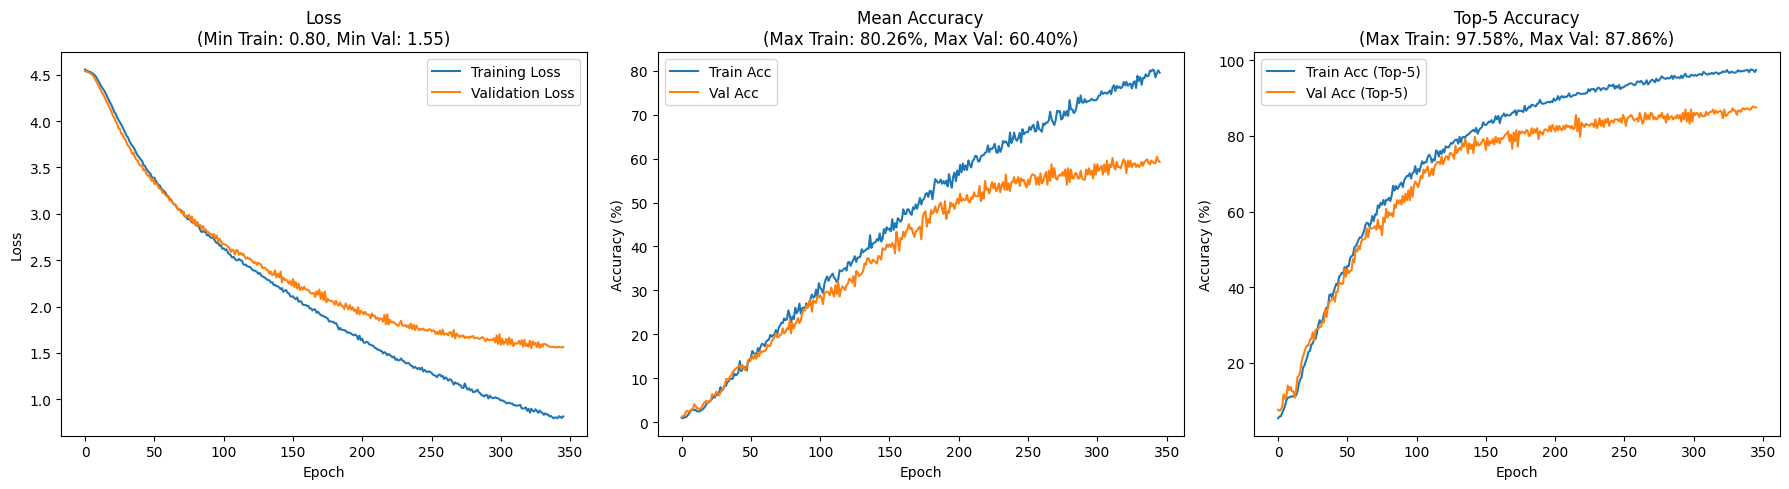

In [11]:
import matplotlib.pyplot as plt

# --- Calculate Min/Max Statistics ---
min_train_loss = min(train_losses)
min_val_loss = min(val_losses)

max_train_acc = max(train_accs)
max_val_acc = max(val_accs)

max_train_top5 = max(train_top5_accs)
max_val_top5 = max(val_top5_accs)

# --- Plotting ---
plt.figure(figsize=(18, 5)) # Wider figure for 3 plots

# 1. Plot Loss
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Loss\n(Min Train: {min_train_loss:.2f}, Min Val: {min_val_loss:.2f})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 2. Plot Top-1 Accuracy
plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title(f'Mean Accuracy\n(Max Train: {max_train_acc:.2f}%, Max Val: {max_val_acc:.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# 3. Plot Top-5 Accuracy
plt.subplot(1, 3, 3)
plt.plot(train_top5_accs, label='Train Acc (Top-5)')
plt.plot(val_top5_accs, label='Val Acc (Top-5)')
plt.title(f'Top-5 Accuracy\n(Max Train: {max_train_top5:.2f}%, Max Val: {max_val_top5:.2f}%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
print("Running final evaluation to generate plots...")

all_labels = []
all_predictions = []
all_scores = []

model.eval() # Ensure model is in eval mode
with torch.no_grad():
    for seqs, labels, _ in val_loader:
        seqs = seqs.to(device)
        labels = labels.to(device)

        outputs = model(seqs)

        # --- For Confusion Matrix ---
        # Get the class with the highest score
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())

        # --- For ROC Curve ---
        # Get the raw probability scores using softmax
        scores = torch.nn.functional.softmax(outputs, dim=1)
        all_scores.append(scores.cpu().numpy())

        # --- For Both ---
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_labels_np = np.array(all_labels)
all_predictions_np = np.array(all_predictions)
all_scores_np = np.concatenate(all_scores, axis=0)

print("Evaluation complete.")

Running final evaluation to generate plots...
Evaluation complete.


Micro-Average ROC AUC: 0.9778


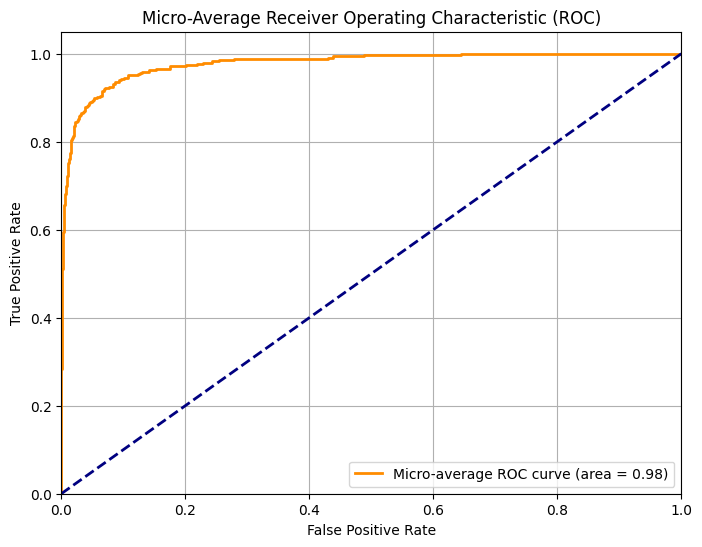

In [13]:
# --- Plot Micro-Average ROC Curve ---
y_true_binarized = label_binarize(all_labels_np, classes=list(range(NUM_CLASSES)))

# Calculate the ROC curve for the "micro-average"
fpr, tpr, _ = roc_curve(y_true_binarized.ravel(), all_scores_np.ravel())
roc_auc = auc(fpr, tpr)

print(f"Micro-Average ROC AUC: {roc_auc:.4f}")

# Plot the curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Micro-average ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [15]:
from collections import Counter

# --- Analyze Top Confusions ---

print("\n--- Top 10 Most Confused Words ---")

# 1. Collect all error pairs
# We look for instances where the prediction does NOT match the label
error_pairs = []

for i in range(len(all_labels_np)):
    true_idx = all_labels_np[i]
    pred_idx = all_predictions_np[i]

    if true_idx != pred_idx:
        # Convert indices back to words using your map
        true_word = index_to_gloss_map[true_idx]
        pred_word = index_to_gloss_map[pred_idx]
        error_pairs.append((true_word, pred_word))

# 2. Count the occurrences of each specific error pair
# e.g., ('APPLE', 'PEAR'): 5 times
error_counts = Counter(error_pairs)

# 3. Get the top 10 most common errors
top_10_errors = error_counts.most_common(10)

# 4. Print them neatly
if not top_10_errors:
    print("Amazing! No errors found in the validation set.")
else:
    print(f"{'True Word':<20} | {'Predicted As':<20} | {'Count':<5}")
    print("-" * 50)
    for (true_word, pred_word), count in top_10_errors:
        print(f"{true_word:<20} | {pred_word:<20} | {count:<5}")

print("-" * 50)

# --- Optional: Print Most Difficult Words (Lowest Recall) ---
# This finds words the model gets wrong *most often* in general
print("\n--- Top 5 'Hardest' Words (Lowest Accuracy) ---")
class_correct = list(0. for i in range(NUM_CLASSES))
class_total = list(0. for i in range(NUM_CLASSES))

for i in range(len(all_labels_np)):
    label = all_labels_np[i]
    pred = all_predictions_np[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

word_accuracies = []
for i in range(NUM_CLASSES):
    if class_total[i] > 0:
        acc = 100 * class_correct[i] / class_total[i]
        word_accuracies.append((index_to_gloss_map[i], acc, class_total[i]))

# Sort by accuracy (ascending)
word_accuracies.sort(key=lambda x: x[1])

for word, acc, total in word_accuracies[:15]:
    print(f"Word: {word:<20} | Accuracy: {acc:.1f}% ({int(total)} samples)")


--- Top 10 Most Confused Words ---
True Word            | Predicted As         | Count
--------------------------------------------------
PEEKABOO             | HALLOWEEN1           | 4    
LUNCH1               | BREAKFAST1           | 3    
WHATFOR1             | PENNY                | 2    
LOCK1                | HOW1                 | 2    
LETTUCE1             | NOON1                | 2    
BEE1                 | CANCER1              | 2    
ALLOFSUDDEN          | PENNY                | 2    
FLIP                 | DOG1                 | 2    
PENNY                | WHATFOR1             | 2    
SHAVE1               | RAZOR2               | 2    
--------------------------------------------------

--- Top 5 'Hardest' Words (Lowest Accuracy) ---
Word: CALENDAR1            | Accuracy: 0.0% (4 samples)
Word: EMPTY2               | Accuracy: 0.0% (3 samples)
Word: FLIP                 | Accuracy: 0.0% (3 samples)
Word: HURDLE/TRIP1         | Accuracy: 0.0% (3 samples)
Word: LUNCH1     